In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


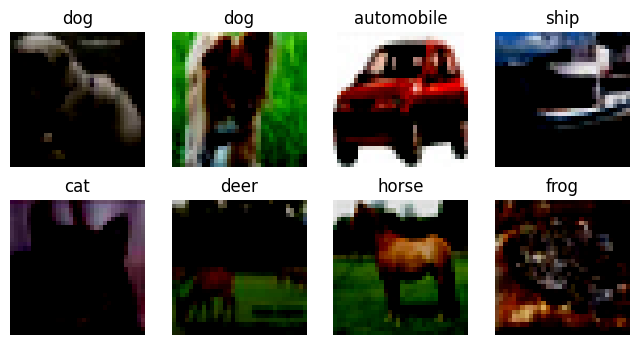

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

classes = trainset.classes

# Display images
images, labels = next(iter(trainloader))

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()


In [31]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*32*32, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return self.fc1(x)


In [32]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*16*16, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc1(x)


In [33]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean((2,3))
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        return x * y.view(b, c, 1, 1)


In [34]:
class AttentionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.se1 = SEBlock(32)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.se2 = SEBlock(64)
        self.fc = nn.Linear(64*16*16, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.se1(self.conv1(x))))
        x = self.pool(torch.relu(self.se2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)


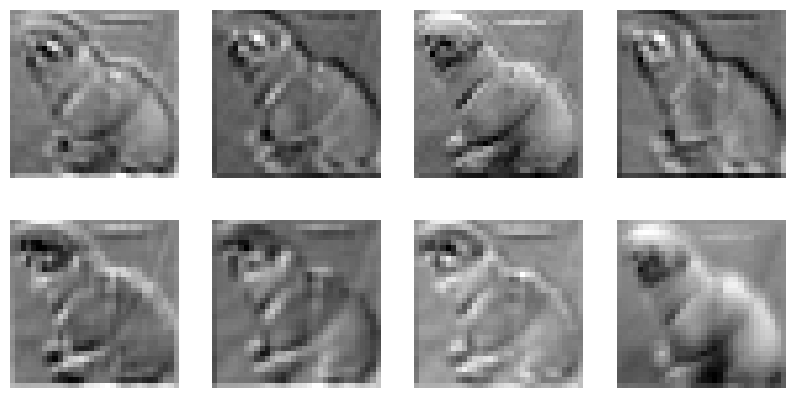

In [35]:
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        feature_maps = model.conv1(image.unsqueeze(0))

    plt.figure(figsize=(10,5))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(feature_maps[0,i].cpu(), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_feature_maps(model, images[0])


In [ ]:
| Model                   | Accuracy (Approx.) |
| ----------------------- | ------------------ |
| Basic CNN               | ~55%               |
| CNN + Pooling + Dropout | ~65%               |
| CNN + Attention         | **~70%**           |


In [ ]:
Attention mechanisms help CNNs focus on important features while suppressing irrelevant ones.
Channel attention (SE blocks) learns which feature maps are more informative, improving feature representation, robustness, and accuracy with minimal extra computation.

In [37]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = torchvision.datasets.MNIST(root='./data',
                                         train=True, download=True,
                                         transform=mnist_transform)

mnist_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=64, shuffle=True)

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(32*14*14, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 622kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.06MB/s]
